## Inferential analysis using bootstrap confidence intervals

This notebook completes the inferential component of the project by quantifying uncertainty in a key pattern observed during exploratory analysis. Specifically, it estimates the difference in mean PC1 scores between the two groups identified by k-means clustering (k = 2) and uses a nonparametric bootstrap procedure to construct a confidence interval for that difference.

PC1 was chosen because it represents the dominant axis of gene expression variation in the TCGA-DLBC dataset, and the k = 2 clustering solution primarily separates samples along this axis. Rather than relying on parametric assumptions (such as normality), bootstrap resampling provides a flexible approach to inference that is well suited for small-sample settings and complex biological data. The analysis begins by reproducing the PCA and k-means clustering steps required to obtain PC1 scores and cluster labels, ensuring that this notebook is self-contained and reproducible.

The inferential target is defined as the difference in mean PC1 between clusters, Δ = mean(PC1 | cluster = 1) − mean(PC1 | cluster = 0). A point estimate is computed from the observed data, and then 10,000 bootstrap resamples are generated by sampling tumors with replacement. For each resample, the difference in mean PC1 is recomputed to form a bootstrap distribution of delta. The 2.5th and 97.5th percentiles of this distribution provide a 95% bootstrap confidence interval, and a histogram of the bootstrap distribution is used to visualize the estimate and its uncertainty. This inferential result directly answers the project’s inferential question by quantifying how confidently the observed separation along PC1 can be attributed to true underlying structure rather than sampling variability.

What is the uncertainty in the difference in mean PC1 scores between the two k-means clusters (k = 2)?

In [2]:
# setup / import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# load
log_cpm = pd.read_parquet("../data/dlbc_log_cpm.parquet")
log_cpm.shape

(23920, 48)

In [4]:
#compute PC1 and k=2 labels same as file 04

# X = samples x genes
X = log_cpm.T

# Standardize features (genes)
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=5, random_state=2025)
pcs = pca.fit_transform(X_scaled)

pc1 = pcs[:, 0]
pc2 = pcs[:, 1]

pca.explained_variance_ratio_[:5]

array([0.21320065, 0.07179766, 0.06302308, 0.04386272, 0.03707331])

In [5]:
#k means on the PCs

kmeans2 = KMeans(n_clusters=2, random_state=2025, n_init=10)
labels_k2 = kmeans2.fit_predict(pcs[:, :5])

np.bincount(labels_k2)

array([24, 24])

In [6]:
# define inferential target and point estimate

pc1_by_cluster = pd.DataFrame({"pc1": pc1, "cluster": labels_k2})

mean0 = pc1_by_cluster.loc[pc1_by_cluster["cluster"] == 0, "pc1"].mean()
mean1 = pc1_by_cluster.loc[pc1_by_cluster["cluster"] == 1, "pc1"].mean()

delta_hat = mean1 - mean0
mean0, mean1, delta_hat

(-65.39104842816894, 65.39104842816893, 130.7820968563379)

In [8]:
# bootstrap the difference in means

rng = np.random.default_rng(2025)

B = 10000
boot_deltas = np.empty(B)

df = pc1_by_cluster.reset_index(drop=True)

for b in range(B):
    samp = df.sample(n=len(df), replace=True, random_state=int(rng.integers(0, 1e9)))
    m0 = samp.loc[samp["cluster"] == 0, "pc1"].mean()
    m1 = samp.loc[samp["cluster"] == 1, "pc1"].mean()
    boot_deltas[b] = m1 - m0

ci_low, ci_high = np.percentile(boot_deltas, [2.5, 97.5])
ci_low, ci_high

(113.97901905307688, 147.1166262019506)

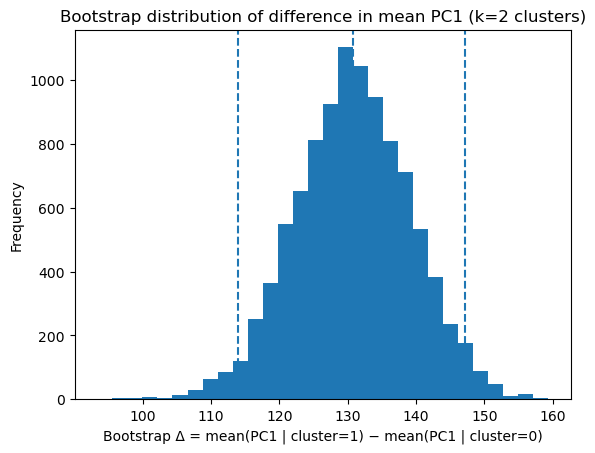

In [9]:
# plot bootstrap distribution

plt.figure()
plt.hist(boot_deltas, bins=30)
plt.axvline(delta_hat, linestyle="--")
plt.axvline(ci_low, linestyle="--")
plt.axvline(ci_high, linestyle="--")
plt.xlabel("Bootstrap Δ = mean(PC1 | cluster=1) − mean(PC1 | cluster=0)")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution of difference in mean PC1 (k=2 clusters)")
plt.show()